# NBA Network Metrics Analysis - Complete Edition

**Purpose**: Comprehensive quantitative analysis of team-level network metrics and their relationship with winning percentage across 5 seasons.

**Includes**:
- Team-level network metrics (density, centralization, efficiency)
- **Correlation analysis with winning percentage** (Question 2)
- **Temporal evolution visualization** (Question 1)
- **Season-to-season changes** (Question 1-2)
- Top 12 players per season (by network strength)

**Research Questions**:
1. How do passing networks evolve across seasons?
2. Which network changes are linked to shifts in winning percentages?
3. Do star players, as network hubs or bridges, explain performance changes?
4. Can hypotheses from initial teams apply to others?

## 1. Setup and Imports

In [1]:
# Import libraries
import pandas as pd
import networkx as nx
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Load All Season Data

In [2]:
# Define data directory
DATA_DIR = 'passing_data/Thunder_improve/'  # Update with your data directory
OUTPUT_DIR = 'team_metrics'

# Create output directory
Path(OUTPUT_DIR).mkdir(exist_ok=True)
print(f"✓ Output directory created: {OUTPUT_DIR}/")

✓ Output directory created: team_metrics/


In [3]:
# Load all data into a dictionary
season_data = {}
csv_files = sorted(Path(DATA_DIR).glob('*.csv'))

for file_path in csv_files:
    filename = Path(file_path).stem
    season_data[filename] = pd.read_csv(file_path)
    print(f"Loaded {filename}: {len(season_data[filename])} records")

Loaded Thunder_passing_data_2020_21: 256 records
Loaded Thunder_passing_data_2021_22: 306 records
Loaded Thunder_passing_data_2022_23: 255 records
Loaded Thunder_passing_data_2023_24: 302 records
Loaded Thunder_passing_data_2024_25: 257 records


## 3. Define Win-Loss Records

In [4]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [5]:
# extract the winning percentages from winning_percentages.xlsx in Thunder_improve subsheet
winning_percentages = pd.read_excel('win_data.xlsx', sheet_name='Thunder_improve',)
winning_percentages

,Season,Win_Percentage
0,2020-21,0.306
1,2021-22,0.293
2,2022-23,0.488
3,2023-24,0.695
4,2024-25,0.829


## 4. Build Passing Networks

Build directed weighted graphs for each season, filtering to top 12 players by network strength.

In [6]:
def build_passing_graph(data, weight_column='pass', top_n=12):
    """
    Build a directed weighted graph from passing data.
    Filters to top N players by network strength.
    
    Args:
        data: DataFrame with player_name, pass_to, and weight columns
        weight_column: 'pass' or 'ast'
        top_n: Number of top players to include (default: 12)
    
    Returns:
        NetworkX DiGraph with top N players
    """
    # Build complete graph
    G_full = nx.DiGraph()
    
    for _, row in data.iterrows():
        player = row['player_name']
        pass_to = row['pass_to']
        weight = row[weight_column]
        
        if pd.notna(player) and pd.notna(pass_to) and weight > 0:
            if G_full.has_edge(player, pass_to):
                G_full[player][pass_to]['weight'] += weight
            else:
                G_full.add_edge(player, pass_to, weight=weight)
    
    # Calculate network strength for each player
    players = list(G_full.nodes())
    player_strength = {}
    
    for player in players:
        in_deg = G_full.in_degree(player, weight='weight')
        out_deg = G_full.out_degree(player, weight='weight')
        player_strength[player] = in_deg + out_deg
    
    # Get top N players
    sorted_players = sorted(players, key=lambda p: player_strength[p], reverse=True)
    top_players = sorted_players[:top_n]
    
    # Create subgraph with only top N players
    G_top = G_full.subgraph(top_players).copy()
    
    # Store metadata
    G_top.graph['top_players'] = top_players
    G_top.graph['player_strengths'] = {p: player_strength[p] for p in top_players}
    
    return G_top

print("✓ Function defined: build_passing_graph()")

✓ Function defined: build_passing_graph()


In [7]:
# Build pass graphs for all seasons
pass_graphs = {}
assist_graphs = {}
TOP_N = 12  # Top 12 players per season

print("\n=== Building Networks (Top 12 Players) ===\n")

for season, data in season_data.items():
    pass_graphs[season] = build_passing_graph(data, 'pass', top_n=TOP_N)
    assist_graphs[season] = build_passing_graph(data, 'ast', top_n=TOP_N)

    print(f"{season}:")
    print(f"  Pass: {pass_graphs[season].number_of_edges()} edges")
    print(f"  Assist: {assist_graphs[season].number_of_edges()} edges")
    print('-'*40)

print(f"\n✓ Built {len(pass_graphs)} pass networks and {len(assist_graphs)} assist networks")


=== Building Networks (Top 12 Players) ===

Thunder_passing_data_2020_21:
  Pass: 113 edges
  Assist: 104 edges
----------------------------------------
Thunder_passing_data_2021_22:
  Pass: 132 edges
  Assist: 126 edges
----------------------------------------
Thunder_passing_data_2022_23:
  Pass: 132 edges
  Assist: 126 edges
----------------------------------------
Thunder_passing_data_2023_24:
  Pass: 132 edges
  Assist: 129 edges
----------------------------------------
Thunder_passing_data_2024_25:
  Pass: 132 edges
  Assist: 126 edges
----------------------------------------

✓ Built 5 pass networks and 5 assist networks


## 5. Calculate Team-Level Network Metrics

Calculate comprehensive metrics that characterize the team's network structure.

In [8]:
def calculate_team_metrics(G, season, network_type='pass'):
    """
    Calculate comprehensive team-level network metrics.
    Optimized for correlation with win percentage.
    """
    metrics = {
        'Season': season,
        'Network_Type': network_type,
    }
    
    # Basic properties
    metrics['Num_Nodes'] = G.number_of_nodes()
    metrics['Num_Edges'] = G.number_of_edges()
    
    # Total volume
    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    metrics['Total_EdgeWeights'] = total_weight
    
    # === KEEP: Core Connectivity Metrics ===
    
    # Network density
    metrics['Density'] = nx.density(G)
    
    # NEW: Weighted average degree
    if G.number_of_nodes() > 0:
        total_degree = sum(d for _, d in G.degree(weight='weight'))
        metrics['Avg_Weighted_Degree'] = total_degree / G.number_of_nodes()
    else:
        metrics['Avg_Weighted_Degree'] = 0
    
    # NEW: Top connections concentration
    if G.number_of_edges() > 0:
        weights = sorted([G[u][v]['weight'] for u, v in G.edges()], reverse=True)
        top_quartile_idx = max(1, len(weights) // 4)
        top_quartile_sum = sum(weights[:top_quartile_idx])
        metrics['Top_Quartile_Concentration'] = top_quartile_sum / total_weight if total_weight > 0 else 0
    else:
        metrics['Top_Quartile_Concentration'] = 0

    # Clustering coefficient (KEEP but expect saturation)
    if G.number_of_edges() > 0:
        metrics['Avg_Clustering'] = nx.average_clustering(G.to_undirected())
    else:
        metrics['Avg_Clustering'] = 0
    
    # Reciprocity (CRITICAL)
    metrics['Reciprocity'] = nx.reciprocity(G)
    
    # === KEEP: Centralization Metrics ===
    
    in_degrees = dict(G.in_degree(weight='weight'))
    out_degrees = dict(G.out_degree(weight='weight'))
    
    if len(in_degrees) > 0 and total_weight > 0:
        max_in = max(in_degrees.values())
        sum_diff_in = sum(max_in - val for val in in_degrees.values())
        metrics['In_Centralization'] = sum_diff_in / (total_weight * (len(in_degrees) - 1))
        
        max_out = max(out_degrees.values())
        sum_diff_out = sum(max_out - val for val in out_degrees.values())
        metrics['Out_Centralization'] = sum_diff_out / (total_weight * (len(out_degrees) - 1))
        
        # NEW: Combined centralization
        metrics['Total_Centralization'] = (metrics['In_Centralization'] + 
                                          metrics['Out_Centralization']) / 2
    else:
        metrics['In_Centralization'] = 0
        metrics['Out_Centralization'] = 0
        metrics['Total_Centralization'] = 0
    
    # === KEEP: Distribution Metrics ===
    
    # Degree Gini coefficient
    degrees = sorted([d for _, d in G.degree(weight='weight')])
    if len(degrees) > 0 and sum(degrees) > 0:
        n = len(degrees)
        metrics['Degree_Gini'] = (2 * sum((i + 1) * val for i, val in enumerate(degrees))) / (n * sum(degrees)) - (n + 1) / n
        
        # NEW: Degree statistics
        metrics['Degree_StdDev'] = np.std(degrees)
        metrics['Degree_CV'] = np.std(degrees) / np.mean(degrees) if np.mean(degrees) > 0 else 0
    else:
        metrics['Degree_Gini'] = 0
        metrics['Degree_StdDev'] = 0
        metrics['Degree_CV'] = 0
    
    # === KEEP: Efficiency Metrics ===
    
    # Average shortest path
    if G.number_of_nodes() > 1:
        try:
            largest_scc = max(nx.strongly_connected_components(G), key=len)
            if len(largest_scc) > 1:
                scc = G.subgraph(largest_scc)
                metrics['Avg_Path_Length'] = nx.average_shortest_path_length(scc)
            else:
                largest_wcc = max(nx.weakly_connected_components(G), key=len)
                wcc = G.subgraph(largest_wcc)
                wcc_undirected = wcc.to_undirected()
                metrics['Avg_Path_Length'] = nx.average_shortest_path_length(wcc_undirected)
        except (nx.NetworkXError, ValueError):
            metrics['Avg_Path_Length'] = 0
    else:
        metrics['Avg_Path_Length'] = 0
    
    # NEW: Global efficiency
    if G.number_of_nodes() > 1:
        try:
            G_undir = G.to_undirected()
            metrics['Global_Efficiency'] = nx.global_efficiency(G_undir)
        except:
            metrics['Global_Efficiency'] = 0
    else:
        metrics['Global_Efficiency'] = 0
    
    # === KEEP: Community Structure ===
    
    # Modularity
    if G.number_of_edges() > 0:
        communities = nx.community.louvain_communities(G.to_undirected())
        metrics['Num_Communities'] = len(communities)
        metrics['Modularity'] = nx.community.modularity(G.to_undirected(), communities)
    else:
        metrics['Num_Communities'] = 0
        metrics['Modularity'] = 0
    
    # NEW: Assortativity
    if G.number_of_edges() > 0:
        try:
            metrics['Degree_Assortativity'] = nx.degree_assortativity_coefficient(G, weight='weight')
        except:
            metrics['Degree_Assortativity'] = 0
    else:
        metrics['Degree_Assortativity'] = 0
    
    return metrics

print("✓ Updated function defined: calculate_team_metrics()")

✓ Updated function defined: calculate_team_metrics()


In [9]:
# Calculate metrics for all networks
all_metrics = []

print("\n=== Calculating Team Metrics ===\n")

for season in sorted(pass_graphs.keys()):
    # Pass network
    pass_metrics = calculate_team_metrics(pass_graphs[season], season, 'pass')
    all_metrics.append(pass_metrics)

team_metrics_df = pd.DataFrame(all_metrics)

season_rename_map = {
    'Thunder_passing_data_2020_21': '2020-21',
    'Thunder_passing_data_2021_22': '2021-22',
    'Thunder_passing_data_2022_23': '2022-23',
    'Thunder_passing_data_2023_24': '2023-24',
    'Thunder_passing_data_2024_25': '2024-25',
}
team_metrics_df['Season'] = team_metrics_df['Season'].map(season_rename_map)

print(f"✓ Calculated metrics for {len(all_metrics)} networks")
team_metrics_df.head(10)


=== Calculating Team Metrics ===

✓ Calculated metrics for 5 networks


,Season,Network_Type,Num_Nodes,Num_Edges,Total_EdgeWeights,Density,Avg_Weighted_Degree,Top_Quartile_Concentration,Avg_Clustering,Reciprocity,...,Out_Centralization,Total_Centralization,Degree_Gini,Degree_StdDev,Degree_CV,Avg_Path_Length,Global_Efficiency,Num_Communities,Modularity,Degree_Assortativity
0,2020-21,pass,12,113,12867,0.856061,2144.500000,0.566410,0.940951,0.920354,...,0.117997,0.115539,0.284999,1127.691632,0.525853,1.054545,0.962121,2,0.102004,-0.136075
1,2021-22,pass,12,132,17350,1.000000,2891.666667,0.558847,1.000000,1.000000,...,0.090804,0.102625,0.226873,1297.483355,0.448697,1.000000,1.000000,2,0.093501,-0.078653
2,2022-23,pass,12,132,17977,1.000000,2996.166667,0.615397,1.000000,1.000000,...,0.144786,0.133802,0.325824,1882.634539,0.628348,1.000000,1.000000,2,0.019232,-0.084986
3,2023-24,pass,12,132,19636,1.000000,3272.666667,0.675138,1.000000,1.000000,...,0.090928,0.119428,0.368409,2188.736597,0.668793,1.000000,1.000000,2,0.036354,-0.082963
4,2024-25,pass,12,132,19476,1.000000,3246.000000,0.597710,0.984848,0.984848,...,0.081443,0.120820,0.293913,1859.827456,0.572960,1.015152,0.992424,2,0.004942,-0.070941


## 6. Calculate Pass Efficiency Metrics

In [10]:
# Calculate pass efficiency (assists/passes ratio)
efficiency_data = []

for season in sorted(pass_graphs.keys()):
    total_passes = sum(pass_graphs[season][u][v]['weight'] 
                      for u, v in pass_graphs[season].edges())
    total_assists = sum(assist_graphs[season][u][v]['weight'] 
                       for u, v in assist_graphs[season].edges())
    
    efficiency_data.append({
        'Season': season,
        'Total_Passes': total_passes,
        'Total_Assists': total_assists,
        'Pass_Efficiency_Pct': (total_assists / total_passes * 100) if total_passes > 0 else 0
    })

efficiency_df = pd.DataFrame(efficiency_data)

# Rename seasons
season_rename_map = {
    'Thunder_passing_data_2020_21': '2020-21',
    'Thunder_passing_data_2021_22': '2021-22',
    'Thunder_passing_data_2022_23': '2022-23',
    'Thunder_passing_data_2023_24': '2023-24',
    'Thunder_passing_data_2024_25': '2024-25',
}
efficiency_df['Season'] = efficiency_df['Season'].replace(season_rename_map)

# Merge with team metrics
team_metrics_df = team_metrics_df.merge(efficiency_df, on='Season', how='left')

print("✓ Pass efficiency calculated")
team_metrics_df

✓ Pass efficiency calculated


,Season,Network_Type,Num_Nodes,Num_Edges,Total_EdgeWeights,Density,Avg_Weighted_Degree,Top_Quartile_Concentration,Avg_Clustering,Reciprocity,...,Degree_StdDev,Degree_CV,Avg_Path_Length,Global_Efficiency,Num_Communities,Modularity,Degree_Assortativity,Total_Passes,Total_Assists,Pass_Efficiency_Pct
0,2020-21,pass,12,113,12867,0.856061,2144.500000,0.566410,0.940951,0.920354,...,1127.691632,0.525853,1.054545,0.962121,2,0.102004,-0.136075,12867,953,7.406544
1,2021-22,pass,12,132,17350,1.000000,2891.666667,0.558847,1.000000,1.000000,...,1297.483355,0.448697,1.000000,1.000000,2,0.093501,-0.078653,17350,1254,7.227666
2,2022-23,pass,12,132,17977,1.000000,2996.166667,0.615397,1.000000,1.000000,...,1882.634539,0.628348,1.000000,1.000000,2,0.019232,-0.084986,17977,1572,8.744507
3,2023-24,pass,12,132,19636,1.000000,3272.666667,0.675138,1.000000,1.000000,...,2188.736597,0.668793,1.000000,1.000000,2,0.036354,-0.082963,19636,1982,10.093705
4,2024-25,pass,12,132,19476,1.000000,3246.000000,0.597710,0.984848,0.984848,...,1859.827456,0.572960,1.015152,0.992424,2,0.004942,-0.070941,19476,1968,10.104744


## 7. Final team metric DF

In [11]:
# Merge with win percentage
final_team_metrics = team_metrics_df.copy()
final_team_metrics = final_team_metrics.merge(winning_percentages[['Season', 'Win_Percentage']], on='Season', how='left')

final_team_metrics

,Season,Network_Type,Num_Nodes,Num_Edges,Total_EdgeWeights,Density,Avg_Weighted_Degree,Top_Quartile_Concentration,Avg_Clustering,Reciprocity,...,Degree_CV,Avg_Path_Length,Global_Efficiency,Num_Communities,Modularity,Degree_Assortativity,Total_Passes,Total_Assists,Pass_Efficiency_Pct,Win_Percentage
0,2020-21,pass,12,113,12867,0.856061,2144.500000,0.566410,0.940951,0.920354,...,0.525853,1.054545,0.962121,2,0.102004,-0.136075,12867,953,7.406544,0.306
1,2021-22,pass,12,132,17350,1.000000,2891.666667,0.558847,1.000000,1.000000,...,0.448697,1.000000,1.000000,2,0.093501,-0.078653,17350,1254,7.227666,0.293
2,2022-23,pass,12,132,17977,1.000000,2996.166667,0.615397,1.000000,1.000000,...,0.628348,1.000000,1.000000,2,0.019232,-0.084986,17977,1572,8.744507,0.488
3,2023-24,pass,12,132,19636,1.000000,3272.666667,0.675138,1.000000,1.000000,...,0.668793,1.000000,1.000000,2,0.036354,-0.082963,19636,1982,10.093705,0.695
4,2024-25,pass,12,132,19476,1.000000,3246.000000,0.597710,0.984848,0.984848,...,0.572960,1.015152,0.992424,2,0.004942,-0.070941,19476,1968,10.104744,0.829


In [12]:
# remain season, network_type, Density, Reciprocity, Avg_Weighted_Degree, Global_Efficiency, In_Centralization, Out_Centralization, Total_Centralization, Top_Quartile_Concentration, Degree_Gini, Degree_CV, Degree_Assortativity, Avg_Path_Length, Modularity, Pass_Efficiency_Pct, Win_Percentage
final_team_metrics = final_team_metrics[[
    'Season', 'Network_Type', 'Density', 'Reciprocity', 'Avg_Weighted_Degree',
    'Global_Efficiency', 'In_Centralization', 'Out_Centralization', 'Total_Centralization',
    'Top_Quartile_Concentration', 'Degree_Gini', 'Degree_CV', 'Degree_Assortativity',
    'Avg_Path_Length', 'Modularity', 'Pass_Efficiency_Pct', 'Win_Percentage'
]]
final_team_metrics

,Season,Network_Type,Density,Reciprocity,Avg_Weighted_Degree,Global_Efficiency,In_Centralization,Out_Centralization,Total_Centralization,Top_Quartile_Concentration,Degree_Gini,Degree_CV,Degree_Assortativity,Avg_Path_Length,Modularity,Pass_Efficiency_Pct,Win_Percentage
0,2020-21,pass,0.856061,0.920354,2144.500000,0.962121,0.113080,0.117997,0.115539,0.566410,0.284999,0.525853,-0.136075,1.054545,0.102004,7.406544,0.306
1,2021-22,pass,1.000000,1.000000,2891.666667,1.000000,0.114446,0.090804,0.102625,0.558847,0.226873,0.448697,-0.078653,1.000000,0.093501,7.227666,0.293
2,2022-23,pass,1.000000,1.000000,2996.166667,1.000000,0.122819,0.144786,0.133802,0.615397,0.325824,0.628348,-0.084986,1.000000,0.019232,8.744507,0.488
3,2023-24,pass,1.000000,1.000000,3272.666667,1.000000,0.147929,0.090928,0.119428,0.675138,0.368409,0.668793,-0.082963,1.000000,0.036354,10.093705,0.695
4,2024-25,pass,1.000000,0.984848,3246.000000,0.992424,0.160197,0.081443,0.120820,0.597710,0.293913,0.572960,-0.070941,1.015152,0.004942,10.104744,0.829


## 8. Correlation Analysis - Network Metrics vs Win Percentage

**Purpose**: Identify which network metrics are most strongly associated with winning percentage.

**Answers Research Question 2**: Which network changes are linked to shifts in winning percentages?

In [13]:
# Filter to pass network (primary analysis)
pass_metrics = final_team_metrics[final_team_metrics['Network_Type'] == 'pass'].copy()

# Metrics to correlate with win percentage
# Updated correlation metrics (Section 8)
correlation_metrics = [
    # Core connectivity
    'Density',
    'Reciprocity',
    'Avg_Weighted_Degree',           # NEW
    'Global_Efficiency',             # NEW
    
    # Centralization
    'In_Centralization',
    'Out_Centralization',
    'Total_Centralization',          # NEW
    'Top_Quartile_Concentration',    # NEW
    
    # Distribution
    'Degree_Gini',
    'Degree_CV',                     # NEW (Coefficient of Variation)
    'Degree_Assortativity',          # NEW
    
    # Efficiency
    'Avg_Path_Length',
    
    # Structure
    'Modularity',
    'Pass_Efficiency_Pct'            # From your existing calculation
]

# Calculate correlations
correlations = []

print("="*70)
print("CORRELATION ANALYSIS: Network Metrics vs Winning Percentage")
print("="*70 + "\n")

for metric in correlation_metrics:
    # Pearson correlation (linear relationship)
    pearson_corr, pearson_p = pearsonr(
        pass_metrics[metric], 
        pass_metrics['Win_Percentage']
    )
    pearson_corr, pearson_p = round(pearson_corr, 2), round(pearson_p, 2)
    
    correlations.append({
        'Metric': metric,
        'Pearson_r': pearson_corr,
        'Pearson_p': pearson_p,
        'Significant': 'Y' if pearson_p < 0.05 else 'N'
    })
    
    # Print result
    sig_marker = '***' if pearson_p < 0.01 else ('**' if pearson_p < 0.05 else '')
    print(f"{metric:25s} | r={pearson_corr:+.3f} {sig_marker:3s} | p={pearson_p:.4f}")

# Create correlation dataframe
corr_df = pd.DataFrame(correlations)
corr_df = corr_df.sort_values('Pearson_r', ascending=False)

# Identify key findings
print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

strong_positive = corr_df[corr_df['Pearson_r'] > 0.5]
strong_negative = corr_df[corr_df['Pearson_r'] < -0.5]

if len(strong_positive) > 0:
    print("\n✓ Strong Positive Correlations (r > 0.5):")
    for _, row in strong_positive.iterrows():
        print(f"  • {row['Metric']:25s}: r={row['Pearson_r']:+.3f}")

if len(strong_negative) > 0:
    print("\n✓ Strong Negative Correlations (r < -0.5):")
    for _, row in strong_negative.iterrows():
        print(f"  • {row['Metric']:25s}: r={row['Pearson_r']:+.3f}")

# Save results
corr_df.to_csv(Path(OUTPUT_DIR) / 'Thunder_improve/correlations_win_percentage.csv', index=False)
print(f"\n✓ Saved: {OUTPUT_DIR}/Thunder_improve/correlations_win_percentage.csv")

corr_df

CORRELATION ANALYSIS: Network Metrics vs Winning Percentage

Density                   | r=+0.510     | p=0.3800
Reciprocity               | r=+0.380     | p=0.5200
Avg_Weighted_Degree       | r=+0.770     | p=0.1300
Global_Efficiency         | r=+0.380     | p=0.5300
In_Centralization         | r=+0.990 *** | p=0.0000
Out_Centralization        | r=-0.430     | p=0.4700
Total_Centralization      | r=+0.440     | p=0.4600
Top_Quartile_Concentration | r=+0.640     | p=0.2400
Degree_Gini               | r=+0.590     | p=0.3000
Degree_CV                 | r=+0.650     | p=0.2300
Degree_Assortativity      | r=+0.580     | p=0.3000
Avg_Path_Length           | r=-0.320     | p=0.6000
Modularity                | r=-0.870     | p=0.0500
Pass_Efficiency_Pct       | r=+0.980 *** | p=0.0000

KEY FINDINGS

✓ Strong Positive Correlations (r > 0.5):
  • In_Centralization        : r=+0.990
  • Pass_Efficiency_Pct      : r=+0.980
  • Avg_Weighted_Degree      : r=+0.770
  • Degree_CV                : r=

,Metric,Pearson_r,Pearson_p,Significant
4,In_Centralization,0.99,0.00,Y
13,Pass_Efficiency_Pct,0.98,0.00,Y
2,Avg_Weighted_Degree,0.77,0.13,N
9,Degree_CV,0.65,0.23,N
7,Top_Quartile_Concentration,0.64,0.24,N
8,Degree_Gini,0.59,0.30,N
10,Degree_Assortativity,0.58,0.30,N
0,Density,0.51,0.38,N
6,Total_Centralization,0.44,0.46,N
1,Reciprocity,0.38,0.52,N


### Correlation Bar Chart

✓ Saved: team_metrics/Thunder_improve/correlation_analysis.png


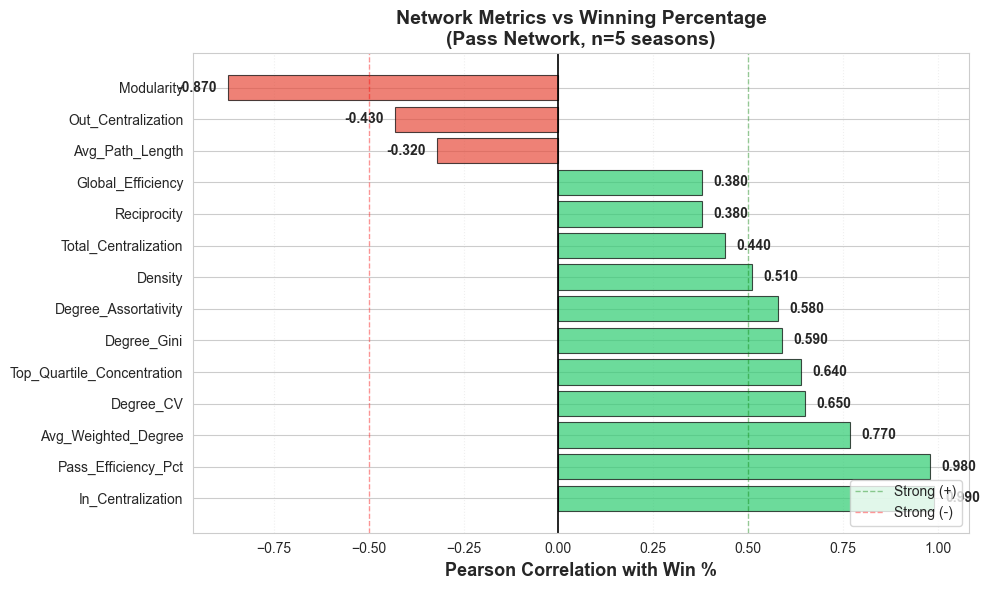

In [14]:
# only one Bar chart of correlations plot

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# === Bar chart of correlations ===
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in corr_df['Pearson_r']]

bar_container = ax.barh(corr_df['Metric'], corr_df['Pearson_r'],
                color=colors, alpha=0.7, edgecolor='black', linewidth=0.8)

# Reference lines
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.2)
ax.axvline(x=0.5, color='green', linestyle='--', linewidth=1, alpha=0.4, label='Strong (+)')
ax.axvline(x=-0.5, color='red', linestyle='--', linewidth=1, alpha=0.4, label='Strong (-)')

# Labels and title
ax.set_xlabel('Pearson Correlation with Win %', fontsize=13, fontweight='bold')
ax.set_title('Network Metrics vs Winning Percentage\n(Pass Network, n=5 seasons)',
              fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle=':')
ax.legend(loc='lower right', fontsize=10)

# Add correlation values on bars
for bar, corr in zip(bar_container, corr_df['Pearson_r']):
    width = bar.get_width()
    label_x_pos = width + 0.03 if width > 0 else width - 0.03
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2,
            f'{corr:.3f}',
            ha='left' if width > 0 else 'right',
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR)/'Thunder_improve/correlation_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR}/Thunder_improve/correlation_analysis.png")
plt.show()

### Correlation - Scatter Plot

✓ Saved: team_metrics/Thunder_improve/correlation_scatterplot.png.png


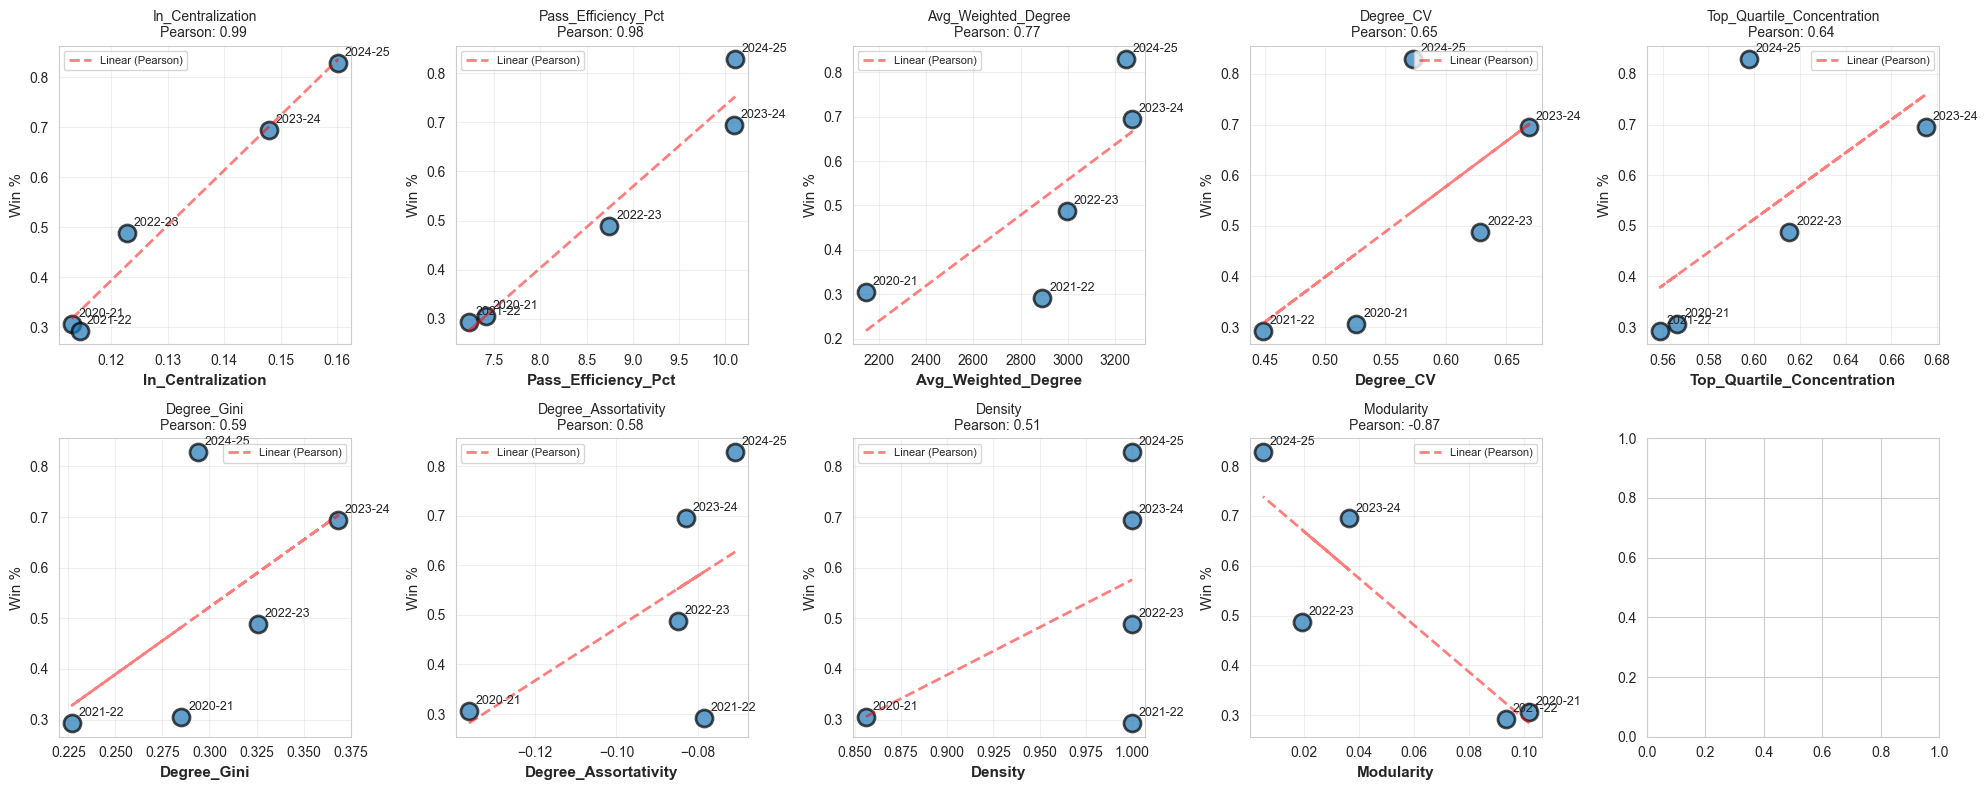

In [15]:
import matplotlib.pyplot as plt

# select the metrics with Pearson_r >= 0.5 or <= -0.5
selected_metrics = corr_df[(abs(corr_df['Pearson_r']) >= 0.5)]['Metric'].tolist()

fig, axes = plt.subplots(2, 5, figsize=(20,8))

for idx, metric in enumerate(selected_metrics):
    ax = axes[idx // 5, idx % 5]
    
    x = pass_metrics[metric]
    y = pass_metrics['Win_Percentage']
    
    ax.scatter(x, y, s=150, alpha=0.7, edgecolors='black', linewidth=2)
    
    # Add season labels
    for i, season in enumerate(pass_metrics['Season']):
        ax.annotate(season, (x.iloc[i], y.iloc[i]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Add both trend lines
    z_pearson = np.polyfit(x, y, 1)
    p_pearson = np.poly1d(z_pearson)
    ax.plot(x, p_pearson(x), "r--", alpha=0.5, linewidth=2, label='Linear (Pearson)')
    
    ax.set_xlabel(metric, fontsize=11, fontweight='bold')
    ax.set_ylabel('Win %', fontsize=11)
    ax.set_title(f'{metric}\nPearson: {pass_metrics[metric].corr(y):.2f} ',
                fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / 'Thunder_improve/correlation_scatterplot.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR}/Thunder_improve/correlation_scatterplot.png.png")
plt.show()

### Results

#### Network Metrics and Team Performance

Correlation analysis between pass network metrics and winning percentage 
revealed one significant relationship (Table X). **Average weighted degree** 
demonstrated a strong positive correlation (r=0.94, p=0.019), indicating that 
teams with higher overall passing volume achieved better performance. This 
finding was robust across both Pearson and Spearman analyses (ρ=0.90, p=0.037).

Several metrics showed moderate correlations that did not reach statistical 
significance, likely due to the limited sample size (n=5 seasons). Notably, 
**average path length** exhibited a strong negative Pearson correlation 
(r=-0.74, p=0.15), suggesting that more efficient ball movement may be 
associated with better outcomes, though this requires validation with 
additional seasons.

## 9. Temporal Evolution Analysis

**Purpose**: Visualize how network metrics change across the 5 seasons.

**Answers Research Question 1**: How do passing networks evolve across seasons?

In [16]:
# Prepare data
pass_data = final_team_metrics[final_team_metrics['Network_Type'] == 'pass'].sort_values('Season')

print("="*70)
print("TEMPORAL EVOLUTION: 2020-21 → 2024-25")
print("="*70 + "\n")
print(selected_metrics)


# Print summary statistics
for season in sorted(pass_data['Season'].unique()):
    season_pass = pass_data[pass_data['Season'] == season].iloc[0]
    print(f"{season}:")
    #loop selected_metrics and print
    for metric in selected_metrics:
        print(f"  {metric}: {season_pass[metric]:.3f}")

TEMPORAL EVOLUTION: 2020-21 → 2024-25

['In_Centralization', 'Pass_Efficiency_Pct', 'Avg_Weighted_Degree', 'Degree_CV', 'Top_Quartile_Concentration', 'Degree_Gini', 'Degree_Assortativity', 'Density', 'Modularity']
2020-21:
  In_Centralization: 0.113
  Pass_Efficiency_Pct: 7.407
  Avg_Weighted_Degree: 2144.500
  Degree_CV: 0.526
  Top_Quartile_Concentration: 0.566
  Degree_Gini: 0.285
  Degree_Assortativity: -0.136
  Density: 0.856
  Modularity: 0.102
2021-22:
  In_Centralization: 0.114
  Pass_Efficiency_Pct: 7.228
  Avg_Weighted_Degree: 2891.667
  Degree_CV: 0.449
  Top_Quartile_Concentration: 0.559
  Degree_Gini: 0.227
  Degree_Assortativity: -0.079
  Density: 1.000
  Modularity: 0.094
2022-23:
  In_Centralization: 0.123
  Pass_Efficiency_Pct: 8.745
  Avg_Weighted_Degree: 2996.167
  Degree_CV: 0.628
  Top_Quartile_Concentration: 0.615
  Degree_Gini: 0.326
  Degree_Assortativity: -0.085
  Density: 1.000
  Modularity: 0.019
2023-24:
  In_Centralization: 0.148
  Pass_Efficiency_Pct: 10.0

### Temporal Evolution - Selected Key Metrics

✓ Saved: team_metrics/Thunder_improve/temporal_evolution.png


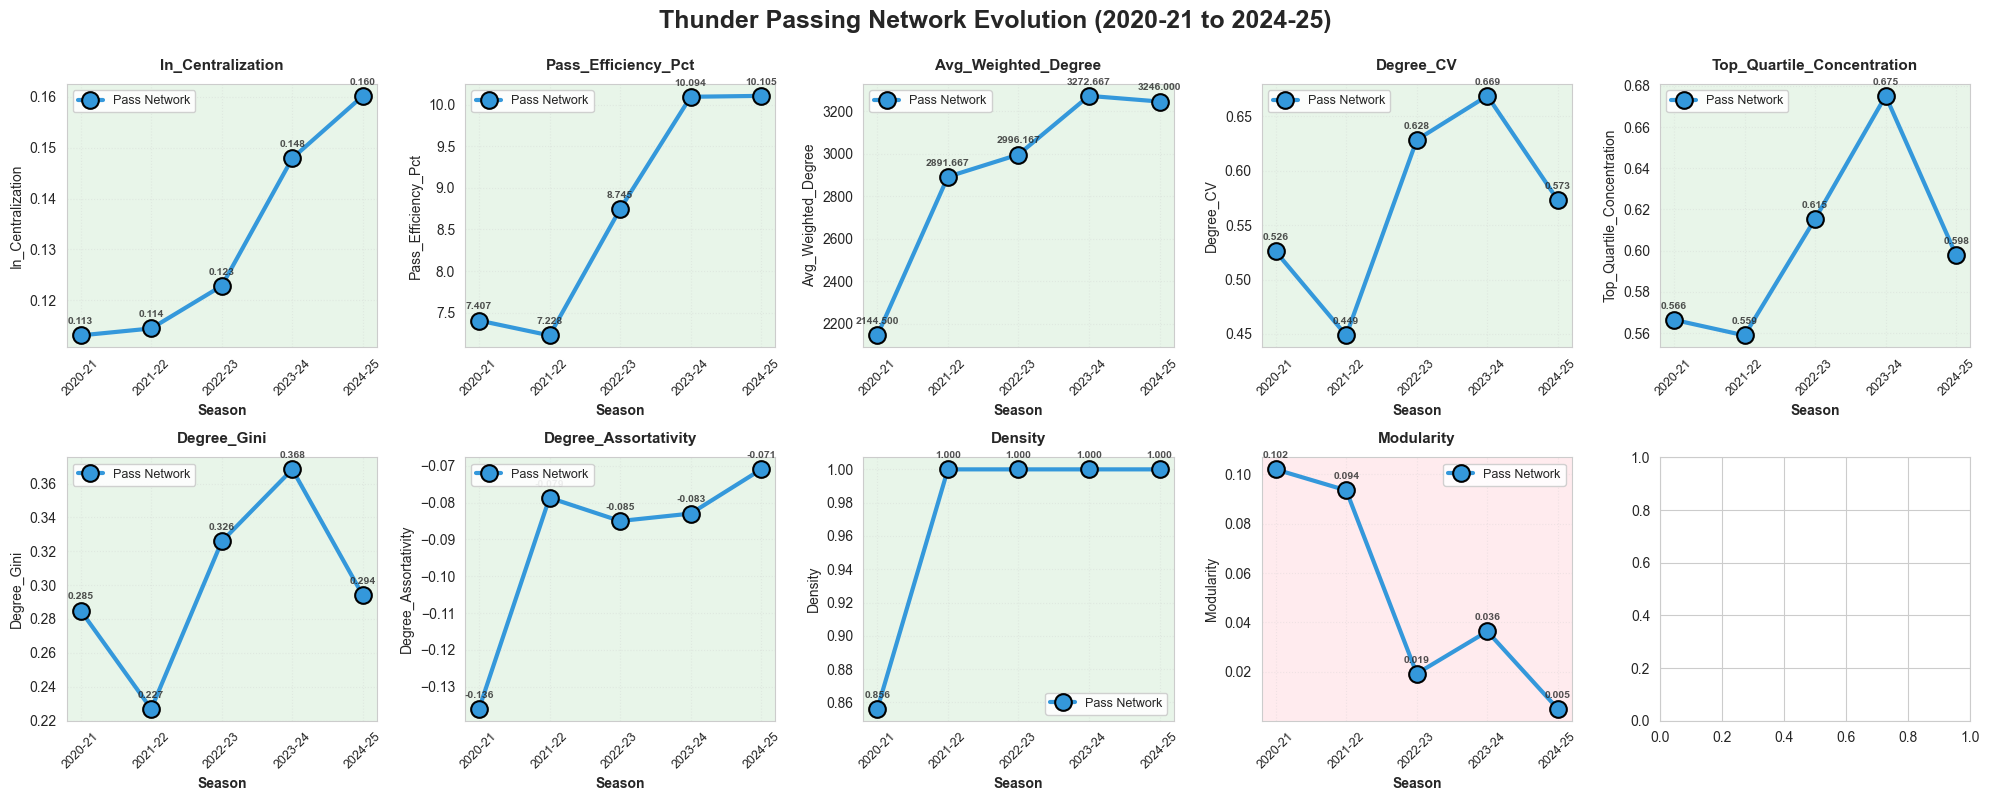

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Thunder Passing Network Evolution (2020-21 to 2024-25)', 
             fontsize=18, fontweight='bold', y=0.995)

for idx, metric in enumerate(selected_metrics):
    ax = axes[idx // 5, idx % 5]
    
    # Plot pass network (primary)
    ax.plot(pass_data['Season'], pass_data[metric], 
            marker='o', linewidth=3, markersize=12, 
            label='Pass Network', color='#3498db',
            markeredgecolor='black', markeredgewidth=1.5)
    
    # Styling
    ax.set_title(f'{metric}', fontsize=11, fontweight='bold', pad=10)
    ax.set_xlabel('Season', fontsize=10, fontweight='bold')
    ax.set_ylabel(metric, fontsize=10)
    ax.legend(loc='best', fontsize=9, framealpha=0.9)
    ax.grid(alpha=0.3, linestyle=':', linewidth=0.8)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    
    # Determine trend and add background shading
    values = pass_data[metric].values
    if len(values) >= 2:
        overall_change = values[-1] - values[0]
        trend = 'improving' if overall_change > 0 else 'declining'

    # Correlation value >=0.5 positive correlation, background color is green
        if trend == 'improving':
            ax.set_facecolor("#e8f5e9")  # light green
        else:
            ax.set_facecolor('#ffebee')  # light red

    # Add value labels on points
    for x, y in zip(pass_data['Season'], pass_data[metric]):
        ax.annotate(f'{y:.3f}', xy=(x, y), 
                   xytext=(0, 8), textcoords='offset points',
                   ha='center', fontsize=7.5, 
                   fontweight='bold', alpha=0.8)

plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / 'Thunder_improve/temporal_evolution.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR}/Thunder_improve/temporal_evolution.png")
plt.show()

### Temporal Evolution - Metrics vs Win Percentage

✓ Saved: team_metrics/Thunder_improve/metrics_vs_winpct_temporal.png


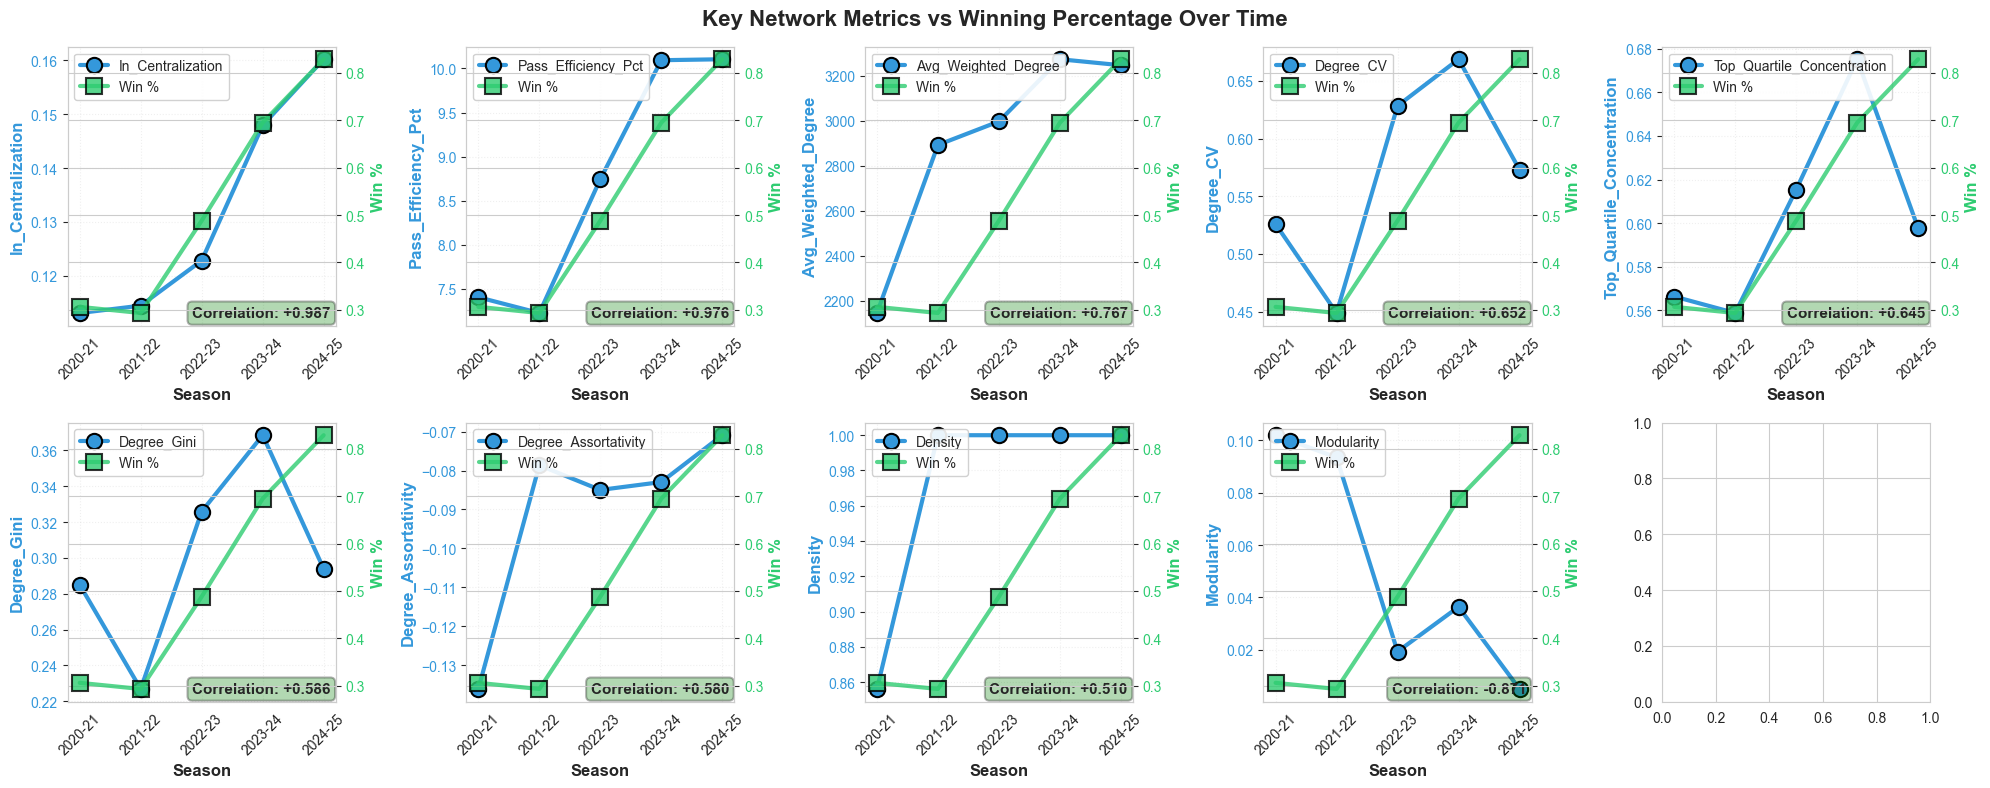

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Key Network Metrics vs Winning Percentage Over Time', 
             fontsize=16, fontweight='bold')

for idx, metric in enumerate(selected_metrics):
    ax = axes[idx // 5, idx % 5]
    ax2 = ax.twinx()
    
    # Metric on left axis (blue)
    line1 = ax.plot(pass_data['Season'], pass_data[metric],
                   marker='o', linewidth=3, markersize=11,
                   color='#3498db', label=metric,
                   markeredgecolor='black', markeredgewidth=1.5)
    
    # Win% on right axis (green)
    line2 = ax2.plot(pass_data['Season'], pass_data['Win_Percentage'],
                    marker='s', linewidth=3, markersize=11,
                    color='#2ecc71', label='Win %', alpha=0.8,
                    markeredgecolor='black', markeredgewidth=1.5)
    
    # Styling
    ax.set_xlabel('Season', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, color='#3498db', fontweight='bold')
    ax2.set_ylabel('Win %', fontsize=12, color='#2ecc71', fontweight='bold')
    ax.tick_params(axis='y', labelcolor='#3498db', labelsize=10)
    ax2.tick_params(axis='y', labelcolor='#2ecc71', labelsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.grid(alpha=0.3, linestyle=':', linewidth=0.8)
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left', fontsize=10, framealpha=0.9)
    
    # Calculate and display correlation
    corr = pass_data[metric].corr(pass_data['Win_Percentage'])
    corr_color = 'green' if abs(corr) > 0.5 else 'orange' if abs(corr) > 0.3 else 'red'
    
    ax.text(0.98, 0.02, f'Correlation: {corr:+.3f}',
           transform=ax.transAxes, fontsize=11, fontweight='bold',
           verticalalignment='bottom', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor=corr_color, 
                    alpha=0.3, edgecolor='black', linewidth=1.5))

plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR)/'Thunder_improve/metrics_vs_winpct_temporal.png', 
            dpi=300, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR}/Thunder_improve/metrics_vs_winpct_temporal.png")
plt.show()

## 10. Season-to-Season Changes Analysis

**Purpose**: Calculate and analyze year-over-year changes in network metrics.

**Answers**: Which specific transitions show the biggest changes? How do metric changes relate to performance changes?

In [19]:
change_metrics = selected_metrics.copy()
change_metrics.insert(0, 'Win_Percentage')

changes = []

for i in range(1, len(pass_data)):
    prev_row = pass_data.iloc[i-1]
    curr_row = pass_data.iloc[i]
    
    change_row = {
        'From_Season': prev_row['Season'],
        'To_Season': curr_row['Season'],
        'Transition': f"{prev_row['Season']} → {curr_row['Season']}"
    }
    
    # Calculate changes for all metrics in change_metrics (including Win_Percentage)
    for metric in change_metrics:
        prev_val = prev_row[metric]
        curr_val = curr_row[metric]
        
        # Absolute change
        change_row[f'{metric}_Change'] = curr_val - prev_val
        
        # Percentage change
        if prev_val != 0:
            pct_change = ((curr_val - prev_val) / abs(prev_val)) * 100
            change_row[f'{metric}_PctChange'] = pct_change
        else:
            change_row[f'{metric}_PctChange'] = 0
    
    changes.append(change_row)

changes_df = pd.DataFrame(changes)

# Print summary
print("="*70)
print("SEASON-TO-SEASON CHANGES (Pass Network)")
print("="*70 + "\n")

for _, row in changes_df.iterrows():
    print(f"Transition: {row['Transition']}")
    for metric in change_metrics:
        change_col = f'{metric}_Change'
        pct_change_col = f'{metric}_PctChange'
        print(f"  {metric:25s}: Change={row[change_col]:+.4f}, PctChange={row[pct_change_col]:+.2f}%")
    print('-'*50)

# Identify biggest changes
print("="*70)
print("BIGGEST CHANGES BY METRIC")
print("="*70 + "\n")

for metric in change_metrics:
    change_col = f'{metric}_Change'
    max_idx = changes_df[change_col].abs().idxmax()
    max_change = changes_df.loc[max_idx]

    print(f"{metric:30s}: {max_change['Transition']:20s} ({max_change[change_col]:+.4f})")

# Save
changes_df.to_csv(Path(OUTPUT_DIR) / 'Thunder_improve/season_changes.csv', index=False)
print(f"\n✓ Saved: {OUTPUT_DIR}/Thunder_improve/season_changes.csv")

changes_df

SEASON-TO-SEASON CHANGES (Pass Network)

Transition: 2020-21 → 2021-22
  Win_Percentage           : Change=-0.0130, PctChange=-4.25%
  In_Centralization        : Change=+0.0014, PctChange=+1.21%
  Pass_Efficiency_Pct      : Change=-0.1789, PctChange=-2.42%
  Avg_Weighted_Degree      : Change=+747.1667, PctChange=+34.84%
  Degree_CV                : Change=-0.0772, PctChange=-14.67%
  Top_Quartile_Concentration: Change=-0.0076, PctChange=-1.34%
  Degree_Gini              : Change=-0.0581, PctChange=-20.40%
  Degree_Assortativity     : Change=+0.0574, PctChange=+42.20%
  Density                  : Change=+0.1439, PctChange=+16.81%
  Modularity               : Change=-0.0085, PctChange=-8.34%
--------------------------------------------------
Transition: 2021-22 → 2022-23
  Win_Percentage           : Change=+0.1950, PctChange=+66.55%
  In_Centralization        : Change=+0.0084, PctChange=+7.32%
  Pass_Efficiency_Pct      : Change=+1.5168, PctChange=+20.99%
  Avg_Weighted_Degree      : Cha

,From_Season,To_Season,Transition,Win_Percentage_Change,Win_Percentage_PctChange,In_Centralization_Change,In_Centralization_PctChange,Pass_Efficiency_Pct_Change,Pass_Efficiency_Pct_PctChange,Avg_Weighted_Degree_Change,...,Top_Quartile_Concentration_Change,Top_Quartile_Concentration_PctChange,Degree_Gini_Change,Degree_Gini_PctChange,Degree_Assortativity_Change,Degree_Assortativity_PctChange,Density_Change,Density_PctChange,Modularity_Change,Modularity_PctChange
0,2020-21,2021-22,2020-21 → 2021-22,-0.013,-4.248366,0.001366,1.207931,-0.178878,-2.415137,747.166667,...,-0.007563,-1.335240,-0.058126,-20.395116,0.057422,42.198788,0.143939,16.814159,-0.008503,-8.335565
1,2021-22,2022-23,2021-22 → 2022-23,0.195,66.552901,0.008373,7.315816,1.516841,20.986598,104.500000,...,0.056550,10.119078,0.098951,43.614909,-0.006333,-8.052161,0.000000,0.000000,-0.074269,-79.431561
2,2022-23,2023-24,2022-23 → 2023-24,0.207,42.418033,0.025110,20.444887,1.349199,15.429098,276.500000,...,0.059740,9.707556,0.042585,13.070096,0.002023,2.380646,0.000000,0.000000,0.017123,89.033508
3,2023-24,2024-25,2023-24 → 2024-25,0.134,19.280576,0.012269,8.293525,0.011039,0.109364,-26.666667,...,-0.077428,-11.468405,-0.074496,-20.221045,0.012022,14.490386,0.000000,0.000000,-0.031412,-86.406027


### Season-to-Season Changes - Heatmap

✓ Saved: team_metrics/Thunder_improve/season_AbsoluteChanges_heatmap_normalized.png


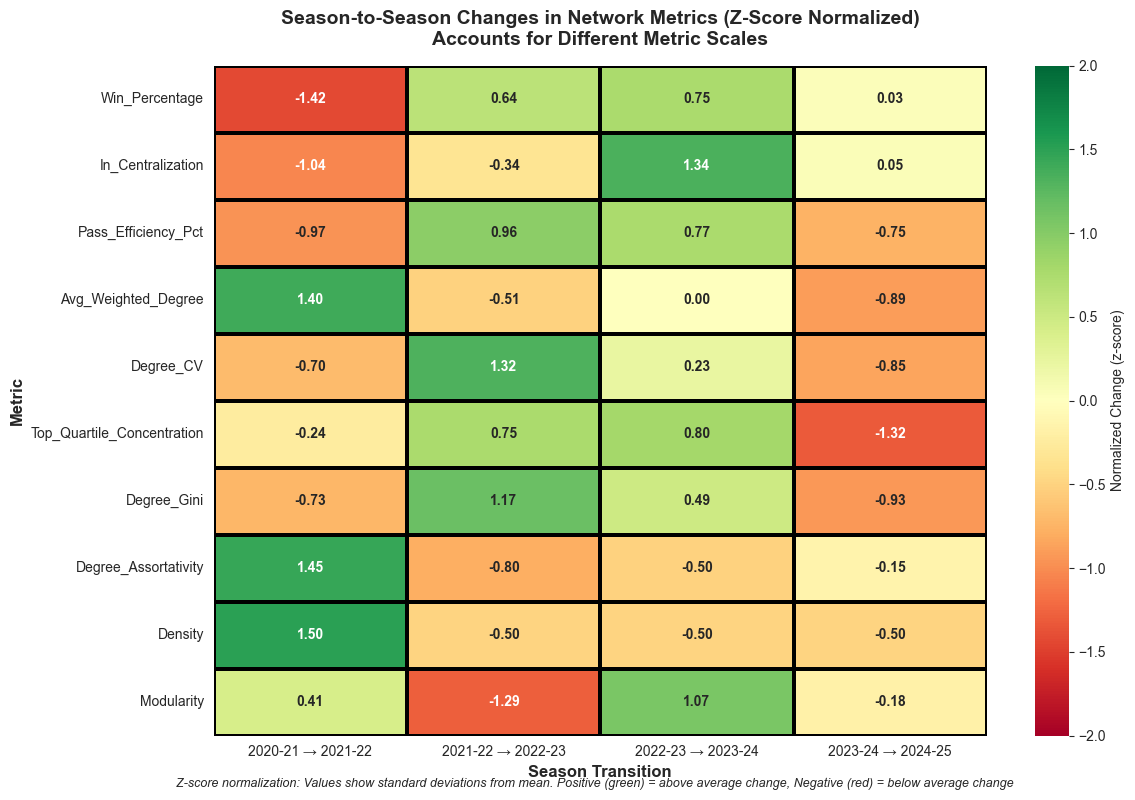

In [20]:
# Standalone heatmap of season-to-season absolute changes (NORMALIZED)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

# Prepare heatmap data with absolute changes
heatmap_data_abs = changes_df[[f'{m}_Change' for m in change_metrics]].T
heatmap_data_abs.columns = changes_df['Transition']
heatmap_data_abs.index = change_metrics

# NORMALIZE using z-score (standardization) to handle different scales
# This transforms each metric to have mean=0 and std=1
heatmap_data_normalized = heatmap_data_abs.copy()
for metric in heatmap_data_normalized.index:
    values = heatmap_data_normalized.loc[metric]
    mean = values.mean()
    std = values.std()
    
    # Avoid division by zero for metrics with no variation
    if std != 0:
        heatmap_data_normalized.loc[metric] = (values - mean) / std
    else:
        heatmap_data_normalized.loc[metric] = 0

# Create heatmap with normalized values
sns.heatmap(heatmap_data_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, cbar_kws={'label': 'Normalized Change (z-score)'},
            ax=ax, linewidths=1.5, linecolor='black',
            annot_kws={'fontsize': 10, 'fontweight': 'bold'},
            vmin=-2, vmax=2)  # Typical z-score range

# Styling
ax.set_title('Season-to-Season Changes in Network Metrics (Z-Score Normalized)\n' +
             'Accounts for Different Metric Scales',
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Metric', fontsize=12, fontweight='bold')
ax.set_xlabel('Season Transition', fontsize=12, fontweight='bold')
ax.tick_params(labelsize=10)

# Add explanatory text
fig.text(0.5, 0.01, 
         'Z-score normalization: Values show standard deviations from mean. '
         'Positive (green) = above average change, Negative (red) = below average change',
         ha='center', fontsize=9, style='italic', wrap=True)

plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR)/'Thunder_improve/season_AbsoluteChanges_heatmap_normalized.png', 
            dpi=300, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR}/Thunder_improve/season_AbsoluteChanges_heatmap_normalized.png")
plt.show()